In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix ,hstack
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from fuzzywuzzy import process, fuzz

In [ ]:
#Add a flush

df_movies = None
df_ratings = None
df_ratings_filt = None
df_filtered = None
df_movies_filtered = None
df_combined = None

------------------------------------------------------------------
Vi laddar båda dataframes med cold start för att skära ut filmer och users så vi har ett mindre men mer värdefullt dataset. Sedan så kombinerar vi vårt dataset till ett mer filtrerat dataset.

Vi gör en EDA, enligt övningarna man skall och några extra, några togs också bort då vi gjorde om en stor del av kod.


Mitt dataset innehåller både ratings och movies med genres. Mitt mål är att skapa ett rekommendationssytem som rekommenderar baserat på ratings och genre. Men jag misslyckades med att få genre att fungera i tid.

Vi använder en sparse matrix eftersom dataset är för stort och det skulle vara väldigt tungt. 

Vi använder K värde för att hitta Nearest Neighbor som i detta fallet är rating. De bäst matchade värden syns.

Jag använder Fuzzy Wuzzy for att identifera en användares input och matcha den till ett ID, sedan tar jag detta ID och identfier filmen och återanvänder den in i find_similar_movies som använder KNN och K=10 för att få fram 10 entries till inputen. 

Primära källor:

Uppvärmningsvideo:
Building a Movie Recommendation system | K-Nearest Neighbors | Machine Learning
https://www.youtube.com/watch?v=4Ws0oPH350U&ab_channel=WennovationAcademy 


Building a MovieLens Recommender System
Toronto Machine Learning Series (TMLS)
https://www.youtube.com/watch?v=XfAe-HLysOM&t=2911s&ab_channel=TorontoMachineLearningSeries%28TMLS%29

LLM används huvudsakligen för att renskriva syntax och debugging. Försöker att skriva så mycket koden jag kan själv och samtidigt fokusera på kodförståelse. LLM får frekvent förfrågan om hur man kan göra saker på olika sätt.

# Labb 1 AI Machine learning advanced

Need to filter the data first since the dataset is 900mb. Looking for different ideas.

In [ ]:
df_movies = pd.read_csv("data/movies.csv", usecols=["movieId", "title", "genres"], dtype={
                        "movieId": "int32", "title": "str", "genres": "str"})

df_ratings = pd.read_csv("data/ratings.csv", dtype={"userId": "int32", "movieId": "int32", "rating": "float32"})

In [ ]:
df_combined = pd.merge(df_ratings, df_movies, on="movieId", how="inner")

In [ ]:
movie_rating_counts = df_combined["movieId"].value_counts()

#Usage of cold start to cut down the dataset. EDA shows there are no 0 entries.
movies_to_keep = movie_rating_counts[movie_rating_counts >= 300].index
df_combined_filtered_movies = df_combined[df_combined["movieId"].isin(
    movies_to_keep)]

user_review_counts = df_combined_filtered_movies["userId"].value_counts()

users_to_keep = user_review_counts[user_review_counts >= 150].index
df_final_filtered = df_combined_filtered_movies[df_combined_filtered_movies["userId"].isin(
    users_to_keep)]

In [ ]:
df_final_filtered

,userId,movieId,rating,timestamp,title,genres
304,7,1,4.0,974518024,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
305,7,3,3.0,974517393,Grumpier Old Men (1995),Comedy|Romance
306,7,11,5.0,974520467,"American President, The (1995)",Comedy|Drama|Romance
307,7,21,2.0,974518824,Get Shorty (1995),Comedy|Crime|Thriller
308,7,25,3.0,974519270,Leaving Las Vegas (1995),Drama|Romance
...,...,...,...,...,...,...
33832157,330975,8340,2.0,1091583256,Escape from Alcatraz (1979),Drama|Thriller
33832158,330975,8493,2.5,1091585709,Memphis Belle (1990),Action|Drama|War
33832159,330975,8622,4.0,1091581777,Fahrenheit 9/11 (2004),Documentary
33832160,330975,8665,3.0,1091581765,"Bourne Supremacy, The (2004)",Action|Crime|Thriller


# EDA and plots!

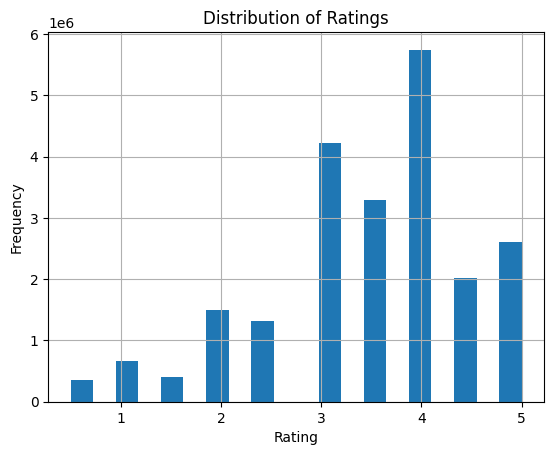

In [140]:
df_final_filtered['rating'].hist(bins=20)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [145]:
#Bigboi everything EDA

print(df_final_filtered.describe())

unique_movies = df_final_filtered["movieId"].nunique()
unique_users = df_final_filtered["userId"].nunique()
print(f"Number of unique movies: {unique_movies}")
print(f"Number of unique users: {unique_users}")

# Distribution of ratings
rating_counts = df_final_filtered["rating"].value_counts().sort_index()
print(rating_counts)

# Most rated movies with movie titles
most_rated_movies_indices = df_final_filtered["movieId"].value_counts().head(
    10).index
most_rated_movies = df_final_filtered[df_final_filtered["movieId"].isin(
    most_rated_movies_indices)]
most_rated_movies = most_rated_movies.groupby(
    "movieId")["title"].first()  # Get the movie title
print(most_rated_movies)

# Highest rated movies (with at least 300 ratings), including movie titles and genres
average_ratings = df_final_filtered.groupby(
    "movieId")["rating"].agg(["mean", "count"])
average_ratings = average_ratings[average_ratings["count"] >= 300]
highest_rated_movies_indices = average_ratings.sort_values(
    by="mean", ascending=False).head(10).index
highest_rated_movies = df_final_filtered[df_final_filtered["movieId"].isin(highest_rated_movies_indices)][[
    "movieId", "title", "genres"]].drop_duplicates().set_index("movieId")
highest_rated_movies["average_rating"] = average_ratings["mean"]
print(highest_rated_movies.sort_values(by="average_rating", ascending=False))

# Ratings per user
ratings_per_user = df_final_filtered["userId"].value_counts()
print(ratings_per_user.describe())

             userId       movieId        rating     timestamp          IMAX  \
count  2.214707e+07  2.214707e+07  2.214707e+07  2.214707e+07  2.214707e+07   
mean   1.652462e+05  2.734288e+04  3.480460e+00  1.285492e+09  4.592268e-02   
std    9.539476e+04  4.717083e+04  1.043255e+00  2.411854e+08  2.093174e-01   
min    7.000000e+00  1.000000e+00  5.000000e-01  8.228736e+08  0.000000e+00   
25%    8.274300e+04  1.371000e+03  3.000000e+00  1.078535e+09  0.000000e+00   
50%    1.658230e+05  3.623000e+03  3.500000e+00  1.272724e+09  0.000000e+00   
75%    2.474140e+05  4.062900e+04  4.000000e+00  1.502054e+09  0.000000e+00   
max    3.309750e+05  2.868970e+05  5.000000e+00  1.689842e+09  1.000000e+00   

            Mystery         Crime       Western      Thriller           War  \
count  2.214707e+07  2.214707e+07  2.214707e+07  2.214707e+07  2.214707e+07   
mean   8.338109e-02  1.662156e-01  1.852452e-02  2.747715e-01  4.792787e-02   
std    2.764574e-01  3.722740e-01  1.348383e-01  4.

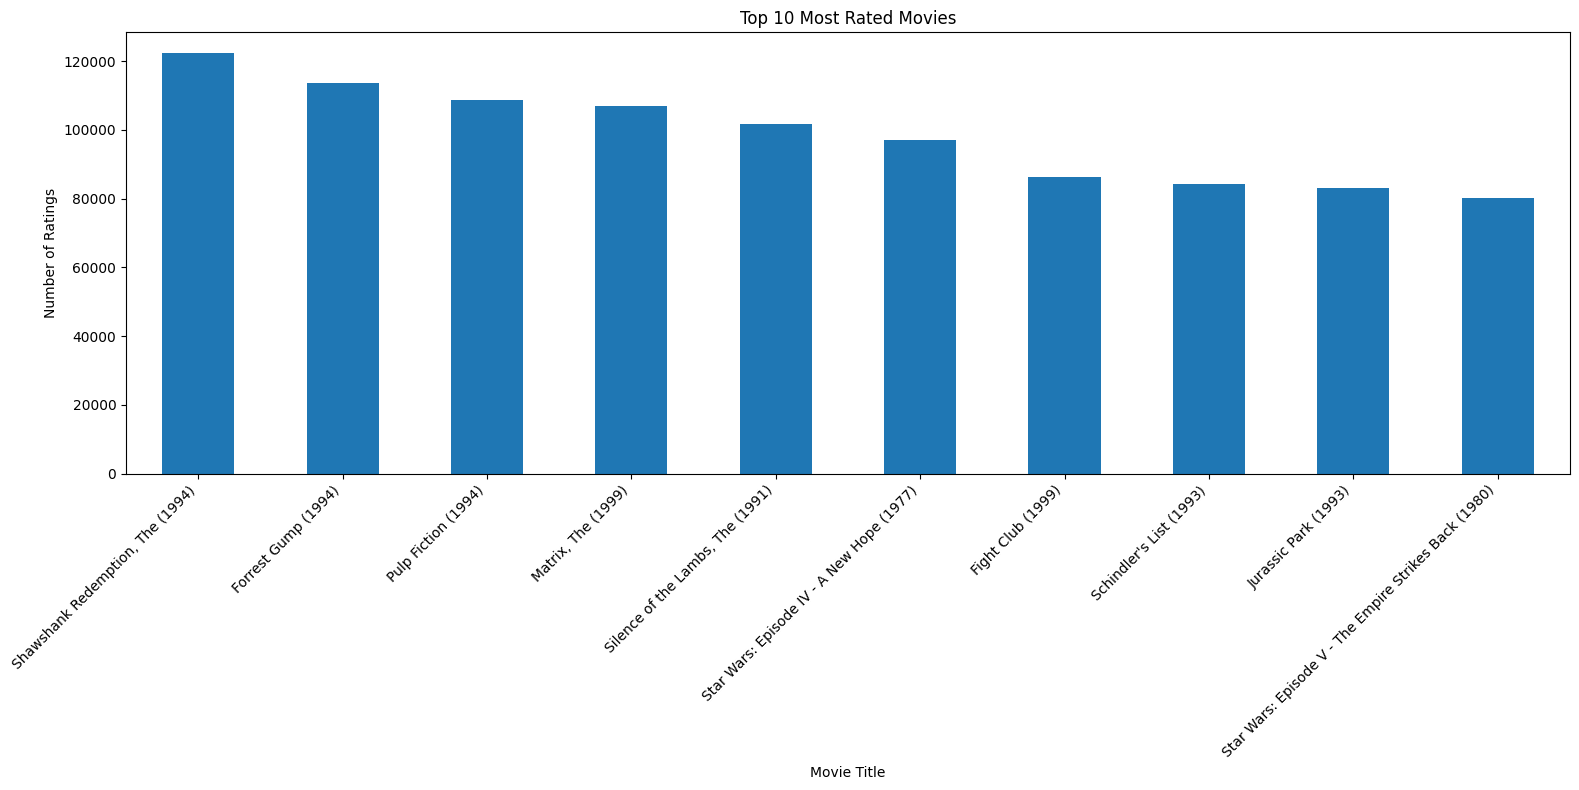

In [146]:
most_rated_movie_ids = df_combined["movieId"].value_counts().head(10).index

most_rated_movies = df_combined[df_combined["movieId"].isin(
    most_rated_movie_ids)]
most_rated_movies = most_rated_movies.groupby("movieId").first()["title"]

rating_counts = df_combined["movieId"].value_counts().loc[most_rated_movie_ids]

# Reorder the titles to match the rating_counts order
ordered_titles = most_rated_movies.reindex(rating_counts.index)

plt.figure(figsize=(16, 8))
rating_counts.plot(kind="bar")
plt.title("Top 10 Most Rated Movies")
plt.xticks(range(len(ordered_titles)), ordered_titles, rotation=45,
           ha="right")  # Set the x-ticks to be the movie titles
plt.xlabel("Movie Title")
plt.ylabel("Number of Ratings")
plt.tight_layout()  # Adjust layout
plt.show()

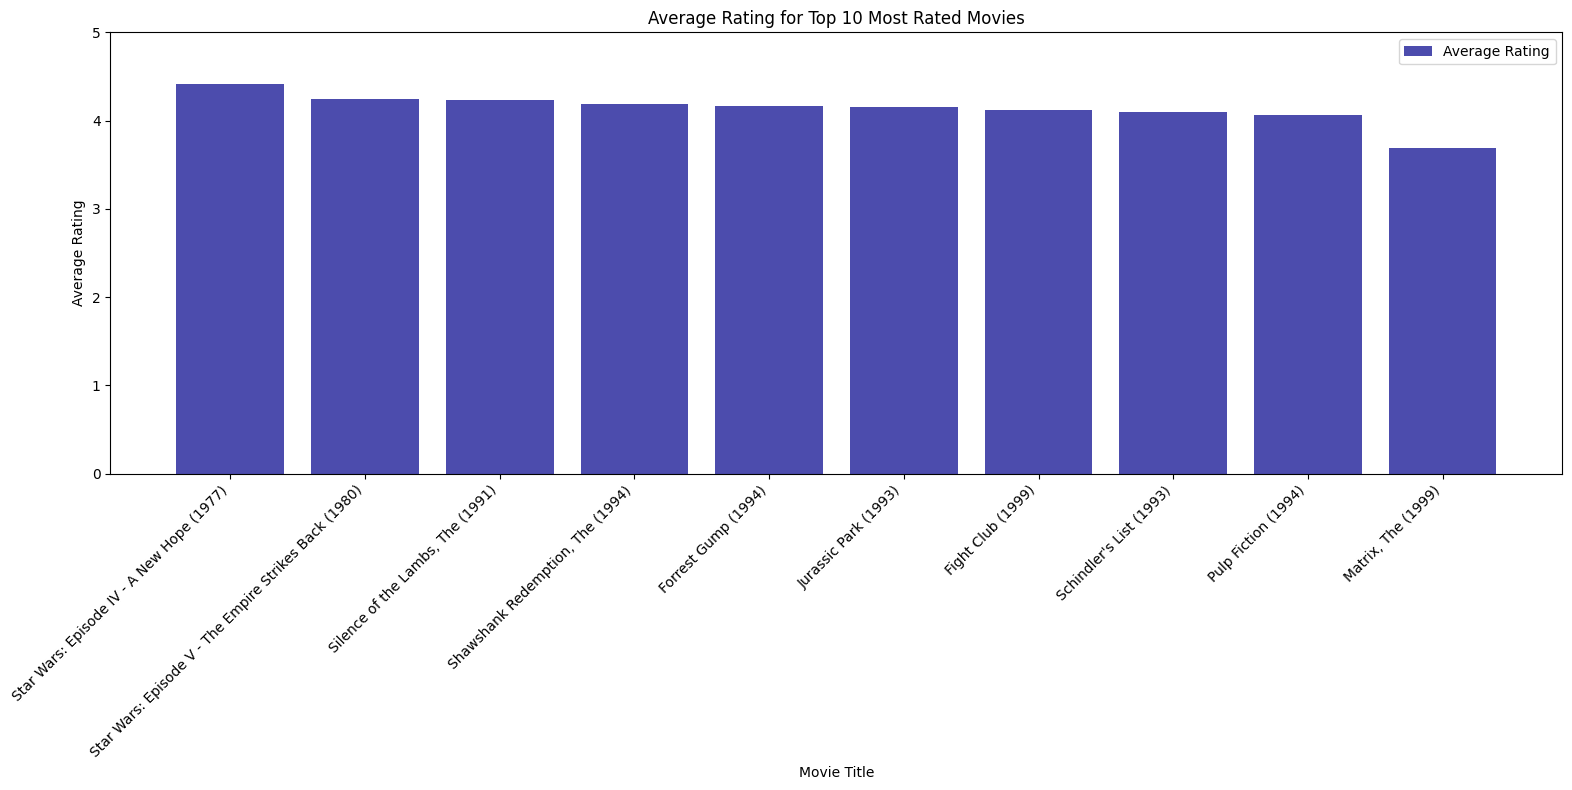

In [80]:
most_rated_movie_ids = df_combined["movieId"].value_counts().head(10).index

most_rated_movies = df_combined[df_combined["movieId"].isin(
    most_rated_movie_ids)]

most_rated_movies = most_rated_movies.groupby("movieId").first()["title"]
average_ratings = df_combined.groupby(
    "movieId")["rating"].mean().loc[most_rated_movie_ids]

most_rated_movies, average_ratings = zip(
    *sorted(zip(most_rated_movies, average_ratings), key=lambda x: x[1], reverse=True))


plt.figure(figsize=(16, 8))

plt.bar(range(len(most_rated_movies)), average_ratings,
        color='darkblue', alpha=0.7, label='Average Rating')

plt.xticks(range(len(most_rated_movies)),
           most_rated_movies, rotation=45, ha="right")
plt.xlabel("Movie Title")
plt.ylabel("Average Rating")
plt.title("Average Rating for Top 10 Most Rated Movies")
plt.ylim(0, 5) 
plt.legend()
plt.tight_layout()
plt.show()

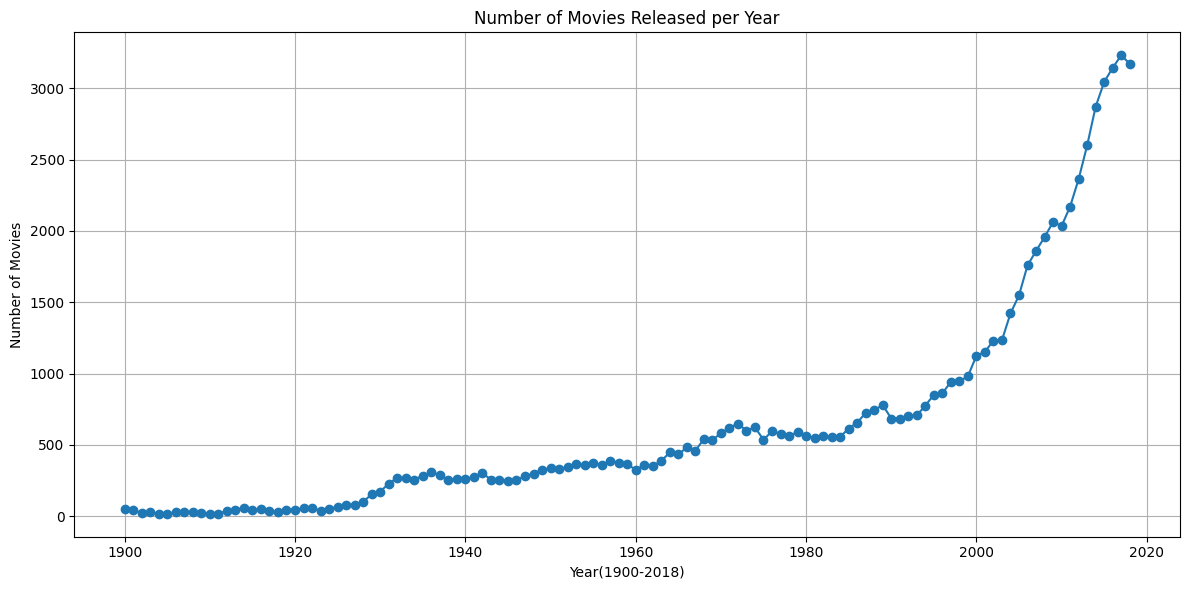

In [256]:
# Just slice out the last part and use it.
release_years = df_movies["title"].str[-5:-1]


release_years = release_years.str.extract("(\d+)").astype(float)  # Gippity

release_years = release_years[(
    release_years >= 1900) & (release_years <= 2018)]

movies_per_year = release_years[0].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(movies_per_year.index, movies_per_year.values,
         marker="o", linestyle="-")
plt.title("Number of Movies Released per Year")
plt.xlabel("Year(1900-2018)")
plt.ylabel("Number of Movies")
plt.grid(True)
plt.tight_layout()
plt.show()

The year release year is in the title, so i i will just slice out the last part and work from there.

# Sparse Matrix/KNN/FuzzyWussyMatch

In [254]:
unique_movie_genres = df_movies.copy()

#unique genres.
unique_genres = set()
df_movies['genres'].str.split('|').apply(unique_genres.update)

# Genre_dictiory
genre_counts = {genre: 0 for genre in unique_genres}

# Binarificationez
for genre in unique_genres:
    unique_movie_genres[genre] = unique_movie_genres['genres'].str.contains(
        genre, regex=False).astype(int)
    genre_counts[genre] = unique_movie_genres[genre].sum()

# SparseMatrixDataHandling
user_movie_rating = df_final_filtered[["userId", "movieId", "rating"]]
user_item_matrix = csr_matrix((user_movie_rating["rating"],
                               (user_movie_rating["userId"], user_movie_rating["movieId"])))


# Remove the movies not meant to be present in the final product
movie_ids_in_final = df_final_filtered["movieId"].unique()
unique_movie_genres_filtered = unique_movie_genres[unique_movie_genres["movieId"].isin(
    movie_ids_in_final)]

In [230]:
#Similiar Matrix to Torono machine learning on Youtube. Not active currently as i struggle to get in genres profficiently.

def create_sparse_matrix(df_final_filtered):

    user_mapper = dict(zip(np.unique(df_final_filtered["userId"]), list(range(df_final_filtered["userId"].nunique()))))
    movie_mapper = dict(zip(np.unique(df_final_filtered["movieId"]), list(range(df_final_filtered["movieId"].nunique()))))
    user_inv_mapper = dict(zip(list(range(df_final_filtered["userId"].nunique())), np.unique(df_final_filtered["userId"])))
    movie_inv_mapper = dict(zip(list(range(df_final_filtered["movieId"].nunique())), np.unique(df_final_filtered["movieId"])))

    user_index = [user_mapper[i] for i in df_final_filtered["userId"]]
    movie_index = [movie_mapper[i] for i in df_final_filtered["movieId"]]

    sparse_matrix = csr_matrix((df_final_filtered["rating"], (user_index, movie_index)), shape=(

        df_final_filtered["userId"].nunique(), df_final_filtered["movieId"].nunique()))
    
    return sparse_matrix, user_mapper, user_inv_mapper, movie_mapper, movie_inv_mapper


sparse_matrix, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_sparse_matrix(
    df_final_filtered)

In [233]:
def knn_ratings_recommendation(data, n_neighbors=5):
    """
    Trains a KNN model using the ratings data and predicts the k-nearest neighbors
    for each item (movie).

    Parameters:
    data (csr_matrix): The user-item rating matrix.
    n_neighbors (int): The number of neighbors to find.

    Returns:
    model (NearestNeighbors): The trained KNN model.
    """
    # Initialize the KNN model
    model = NearestNeighbors(
        metric='cosine', algorithm='brute', n_neighbors=n_neighbors, n_jobs=-1)

    # Fit the model to the data
    model.fit(data)

    return model


user_item_matrix = csr_matrix((user_movie_rating["rating"],
                              (user_movie_rating["userId"], user_movie_rating["movieId"])))

In [234]:
#Training model.

knn_model = knn_ratings_recommendation(user_item_matrix, n_neighbors=20)

    Parameters:
    item_index (int): The index of the item in the user-item matrix.
    user_item_matrix (csr_matrix): The user-item matrix used by the KNN model.
    movie_info_df (DataFrame): DataFrame containing movieId, title, and genres.
    knn_model (NearestNeighbors): The trained KNN model.
    k (int): The number of similar movies to find.

In [245]:
def find_similar_movies(item_index, user_item_matrix, movie_info_df, knn_model, k=5):

   # similar_movies (list of str): List of movie titles that are similar to the given item.
    distances, indices = knn_model.kneighbors(user_item_matrix[item_index], n_neighbors=k+1)
    
    # Indices are the column indices in user_item_matrix which correspond to movieIds in movie_info_df
    movie_indices = indices.flatten()[1:]
    movie_ids = [movie_info_df.iloc[index]["movieId"] for index in movie_indices]
    

    similar_movies = [movie_info_df[movie_info_df["movieId"] == movie_id]["title"].iloc[0] for movie_id in movie_ids]
    
    return similar_movies

In [246]:
from fuzzywuzzy import process

def get_closest_movie_id(input_title, df):
    # Extract unique movie titles
    unique_titles = df[["movieId", "title"]
                       ].drop_duplicates().set_index("movieId")

    # Use fuzzy matching to find the closest movie title
    closest_match = process.extractOne(input_title, unique_titles["title"])

    # Get the movieId that corresponds to the closest match
    closest_movie_id = unique_titles[unique_titles["title"]
                                     == closest_match[0]].index[0]

    return closest_movie_id

# Example usage:
input_title = "toy story"  # Or any other movie title
matched_movie_id = get_closest_movie_id(input_title, df_final_filtered)
print(f"The movieId for "{input_title}" is: {matched_movie_id}")

The movieId for 'toy story' is: 1


In [251]:
sparse_matrix.shape
#User/Movies

(55888, 7876)

In [194]:
def check_indices_alignment(user_item_matrix, df_final_filtered):
    print("Checking if indices in user_item_matrix align with df_final_filtered...")
    
    
    # Check if movie indices in user_item_matrix correspond to movieId in df_final_filtered
    movie_ids = df_final_filtered['movieId'].unique()
    for i, movie_id in enumerate(movie_ids[:5]):
        movie_title = df_final_filtered[df_final_filtered['movieId'] == movie_id]['title'].iloc[0]
        print(f"Index {i} in user_item_matrix corresponds to movieId {movie_id} with title {movie_title}")
        assert movie_id in df_final_filtered['movieId'].values, "Index mismatch found."
    print("Indices in user_item_matrix align with df_final_filtered.")


check_indices_alignment(user_item_matrix, df_final_filtered)

Checking if indices in user_item_matrix align with df_final_filtered...
Index 0 in user_item_matrix corresponds to movieId 1 with title Toy Story (1995)
Index 1 in user_item_matrix corresponds to movieId 3 with title Grumpier Old Men (1995)
Index 2 in user_item_matrix corresponds to movieId 11 with title American President, The (1995)
Index 3 in user_item_matrix corresponds to movieId 21 with title Get Shorty (1995)
Index 4 in user_item_matrix corresponds to movieId 25 with title Leaving Las Vegas (1995)
Indices in user_item_matrix align with df_final_filtered.


# Movie Recommendation query

In [258]:
X = input("Enter a movie title: ")
matched_movie_id = get_closest_movie_id(X, df_final_filtered)
matched_movie_title = df_final_filtered[df_final_filtered['movieId']
                                        == matched_movie_id]['title'].values[0]
print(f"Match for: '{matched_movie_title}' isMovieID: {matched_movie_id}")

top_similar_movies = find_similar_movies(
    matched_movie_id, user_item_matrix, df_final_filtered, knn_model, k=10)

print(f"Top 5 similar movies to the movie '{X}':")
for title in top_similar_movies:
    print(title)

Match for: 'Silence of the Lambs, The (1991)' isMovieID: 593
Top 5 similar movies to the movie 'Silence of the lamb':
Birds, The (1963)
Waiting for Guffman (1996)
Raising Arizona (1987)
Citizen Ruth (1996)
Jaws 2 (1978)
Jaws (1975)
Grease (1978)
Breaking the Waves (1996)
Donnie Brasco (1997)
Some Kind of Wonderful (1987)


------------------------------------------------------------------
Vi laddar båda dataframes med cold start för att skära ut filmer och users så vi har ett mindre men mer värdefullt dataset. Sedan så kombinerar vi vårt dataset till ett mer filtrerat dataset.

Vi gör en EDA, enligt övningarna man skall och några extra, några togs också bort då vi gjorde om en stor del av kod.


Mitt dataset innehåller både ratings och movies med genres. Mitt mål är att skapa ett rekommendationssytem som rekommenderar baserat på ratings och genre. Men jag misslyckades med att få genre att fungera i tid.

Vi använder en sparse matrix eftersom dataset är för stort och det skulle vara väldigt tungt. 

Vi använder K värde för att hitta Nearest Neighbor som i detta fallet är rating. De bäst matchade värden syns.

Jag använder Fuzzy Wuzzy for att identifera en användares input och matcha den till ett ID, sedan tar jag detta ID och identfier filmen och återanvänder den in i find_similar_movies som använder KNN och K=10 för att få fram 10 entries till inputen. 

Primära källor:

Uppvärmningsvideo:
Building a Movie Recommendation system | K-Nearest Neighbors | Machine Learning
https://www.youtube.com/watch?v=4Ws0oPH350U&ab_channel=WennovationAcademy 


Building a MovieLens Recommender System
Toronto Machine Learning Series (TMLS)
https://www.youtube.com/watch?v=XfAe-HLysOM&t=2911s&ab_channel=TorontoMachineLearningSeries%28TMLS%29

ChatGPT används primärt för att renskriva syntax, debugging. Försöker att skriva så mycket koden jag kan själv och samtidigt fokusera på kodförståelse.